# Lab 10 - Clustering Analysis with Spark MLlib

In this lab, we will explore machine learning with Spark MLlib module. Specifically, we will play around how to do a KMeans Clustering to explore how many types of Wines are there in our wine dataset.

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1b54b597573857fb80456c4bf467778b824b5a64c1641de93e2b64501d5a77e8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
## Other packages will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Start a SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

Let's first upload the `wine.csv` into Google Colab using the left file tab.

The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine.

It contains the following features that describe the wine.

* Alcohol
* Malic acid
* Ash
* Alcalinity of ash
* Magnesium
* Total phenols
* Flavanoids
* Nonflavanoid phenols
* Proanthocyanins
* Color intensity
* Hue
* OD280/OD315 of diluted wines
* Proline

## Load DataSet

In [3]:
# Loads data.
wine = spark.read.load("wine.csv", format="csv", sep=",", inferSchema=True, header=True)
wine.show(5)

+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|od280/od315_of_diluted_wines|proline|
+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|  14.23|      1.71|2.43|             15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92| 1065.0|
|   13.2|      1.78|2.14|             11.2|    100.0|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|                         3.4| 1050.0|
|  13.16|      2.36|2.67|             18.6|    101.0|          2.8|      3.24|                 0.3|           2.81|           5.68

This is a typical clustering dataset, in which we have a set of features (X)describe different aspects of wines, but no target variable (Y). Here, we want to ues KMeans to describe the underlying characteristics of wines --  clustering wines into a small set of groups where wine in each group share similar characteristics.

## Exam the Data and Preprocessing

In [4]:
## first let's check the dataset's schema
wine.printSchema()

root
 |-- alcohol: double (nullable = true)
 |-- malic_acid: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcalinity_of_ash: double (nullable = true)
 |-- magnesium: double (nullable = true)
 |-- total_phenols: double (nullable = true)
 |-- flavanoids: double (nullable = true)
 |-- nonflavanoid_phenols: double (nullable = true)
 |-- proanthocyanins: double (nullable = true)
 |-- color_intensity: double (nullable = true)
 |-- hue: double (nullable = true)
 |-- od280/od315_of_diluted_wines: double (nullable = true)
 |-- proline: double (nullable = true)



In [5]:
## check how many instances
wine.count()

178

In [6]:
## check for how many features
len(wine.columns)

13

In [7]:
## show data destribution
wine.describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+----------------------------+-----------------+
|summary|           alcohol|        malic_acid|               ash|alcalinity_of_ash|         magnesium|     total_phenols|        flavanoids|nonflavanoid_phenols|   proanthocyanins|  color_intensity|                hue|od280/od315_of_diluted_wines|          proline|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+----------------------------+-----------------+
|  count|               178|               178|               178|              178|               178|               178|               178|                 178|               178|              178|

From the above distribution, we see that different features have different scale. For example, the *alcohol* feature range from 11 to 14 whereas *malic_acid* feature ranges from 0.74 to 5.8 (other features also have different scale).

In [8]:
## check for missing values
missing_values = {col:wine.filter(wine[col].isNull()).count() for col in wine.columns}  # this list comprehension show the number of missing value in each column
missing_values

{'alcohol': 0,
 'malic_acid': 0,
 'ash': 0,
 'alcalinity_of_ash': 0,
 'magnesium': 0,
 'total_phenols': 0,
 'flavanoids': 0,
 'nonflavanoid_phenols': 0,
 'proanthocyanins': 0,
 'color_intensity': 0,
 'hue': 0,
 'od280/od315_of_diluted_wines': 0,
 'proline': 0}

MLlib models take vector as input. Right now, the features we are going to use are saved in different columns. Let's first convert them into Vectors and saved them into a new column in the dataframe.

Luckly, MLlib is very similar to `sklearn` package: they both provide awesome preprocessing and ultility functions.

In [9]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [ ]:
wine.columns

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [10]:
## select a set of features we are going to use for clustering
# features = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids',
            # 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
features = wine.columns

In [11]:
## assemble all the features we want to use into one vector and save it into the "features" column in wine2
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
wine2 = vector_assembler.transform(wine)

In [22]:
wine2.show(5)

+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+--------------------+--------------------+
|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|od280/od315_of_diluted_wines|proline|            features|     scaled_features|
+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+--------------------+--------------------+
|  14.23|      1.71|2.43|             15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92| 1065.0|[14.23,1.71,2.43,...|[1.51434076729214...|
|   13.2|      1.78|2.14|             11.2|    100.0|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|

In previous analysis, we found that different features have different scale -- This is likely to cause troubles in clustering because KMeans assign data points to groups based on their distances to the center point. So, in order to overcome this, we will usually standardize the features to make them all have a mean=0 and std= 1. The standardization follows this formula:

$$Z = \frac{x_i - \mu}{\sigma}$$

Similar to sklearn, MLlib also offer a `StandardScaler` to streamline the process.

In [29]:
from pyspark.ml.feature import StandardScaler

In [30]:
## initialize the standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

## fit with the wine dataset
scaler_model = scaler.fit(wine2)

## write the output to overwrite wine2
wine2 = scaler_model.transform(wine2)

IllegalArgumentException: requirement failed: Output column scaled_features already exists.

In [31]:
wine2.show(5)

+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+--------------------+--------------------+
|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|od280/od315_of_diluted_wines|proline|            features|     scaled_features|
+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+--------------------+--------------------+
|  14.23|      1.71|2.43|             15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92| 1065.0|[14.23,1.71,2.43,...|[1.51434076729214...|
|   13.2|      1.78|2.14|             11.2|    100.0|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|

## Start Clustering with KMeans

In [15]:
## import KMeans from pyspark MLlib

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [16]:
# initialize KMeans model
## here we specify that we are going to use the scaled_features column as our feature and fit a Kmeans model with 3 clusters.
kmeans = KMeans(featuresCol = "scaled_features", k=3)
## fit the actual data
model = kmeans.fit(wine2)

In [17]:
model

KMeansModel: uid=KMeans_5b17fd72f7e0, k=3, distanceMeasure=euclidean, numFeatures=13

In [18]:
# Make prediction / assign wines into category
predictions = model.transform(wine2)

In [20]:
predictions.show(5)

+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+--------------------+--------------------+----------+
|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|od280/od315_of_diluted_wines|proline|            features|     scaled_features|prediction|
+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+--------------------+--------------------+----------+
|  14.23|      1.71|2.43|             15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92| 1065.0|[14.23,1.71,2.43,...|[1.51434076729214...|         0|
|   13.2|      1.78|2.14|             11.2|    100.0|         2.65|      2.76|              

In [21]:
## check how many wines per category

predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   49|
|         2|   62|
|         0|   67|
+----------+-----+



Unlike Classification, Clustering usually doesn't have a definative evaluation metric such as accuracy. Our target is often strike a balance between simplicity/explainability and accurately reflect the underlying data structure. (By grouping similar data points together, clustering helps to simplify and summarize large datasets into a more manageable form.)

Because the target of clustering is to group data points so that those within each group (or cluster) are more similar to each other than they are to data points in other clusters. there are a set of measures we could use to calculate how the exisiting clustering reflect the underlying data distribution.

**Silhouette score** is one of them.
- check more about this measure here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html


In [32]:
# Evaluate clustering by computing Silhouette score

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaled_features")
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = ", silhouette)

Silhouette with squared euclidean distance =  0.4461668536664658


## Interpret clustering result

In [33]:
# Shows the center point of each cluster.
centers = model.clusterCenters()
print("Cluster Centers: ")
for id,center in enumerate(centers):
  print(id)
  print(center)
  print("=="*20)

Cluster Centers: 
0
[ 0.72893661 -0.35826013  0.27873115 -0.56921026  0.5991209   0.86753444
  0.92820762 -0.60733827  0.60784783  0.10666642  0.49893826  0.74810928
  1.02357247]
1
[ 0.1860184   0.90242582  0.24850925  0.58206156 -0.05049296 -0.98577624
 -1.2327174   0.71482528 -0.74749896  0.98571769 -1.18794772 -1.2978785
 -0.37897557]
2
[-0.93473636 -0.32605542 -0.49761194  0.15509792 -0.60753138 -0.15841568
 -0.02881868  0.0913746  -0.06610251 -0.8943035   0.39968669  0.21730201
 -0.80660569]


<Axes: >

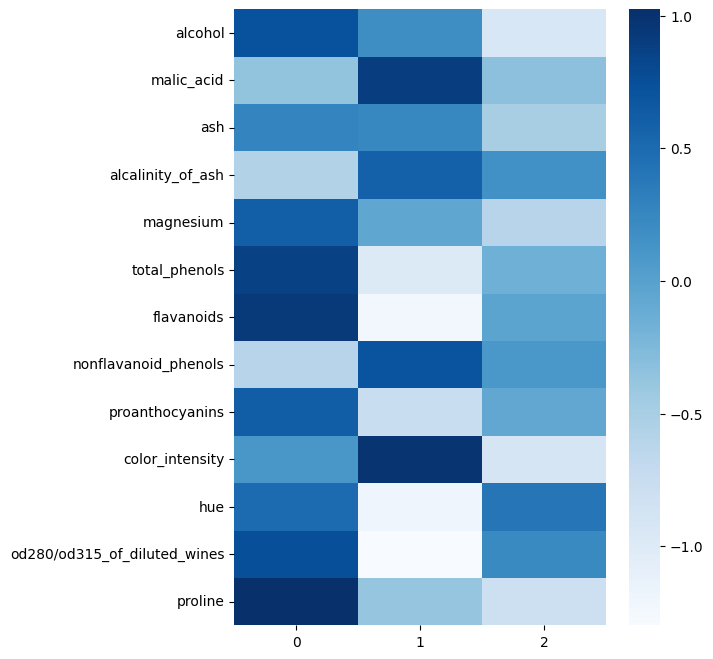

In [34]:
centers = pd.DataFrame(centers, columns=features)
plt.figure(figsize=(6,8))
sns.heatmap(centers.T, cmap="Blues")

## Practice

- Calculate the average value of all the features for each cluster.
- Try to fit a KMeans model with 4 clusters (k=4), which KMeans model gets a higher Silhouette score?

In [36]:
## your code here
from pyspark.sql import functions as F


In [37]:
predictions.groupBy("prediction").agg(F.avg("alcohol")).show()

+----------+------------------+
|prediction|      avg(alcohol)|
+----------+------------------+
|         1|13.151632653061224|
|         2|12.241774193548386|
|         0|13.592388059701495|
+----------+------------------+



In [39]:
for feature in features:
    predictions.groupBy("prediction").agg(F.avg(feature)).show()

+----------+------------------+
|prediction|      avg(alcohol)|
+----------+------------------+
|         1|13.151632653061224|
|         2|12.241774193548386|
|         0|13.592388059701495|
+----------+------------------+

+----------+------------------+
|prediction|   avg(malic_acid)|
+----------+------------------+
|         1| 3.344489795918368|
|         2|1.9720967741935485|
|         0| 1.936119402985075|
+----------+------------------+

+----------+------------------+
|prediction|          avg(ash)|
+----------+------------------+
|         1|  2.43469387755102|
|         2|              2.23|
|         0|2.4429850746268658|
+----------+------------------+

+----------+----------------------+
|prediction|avg(alcalinity_of_ash)|
+----------+----------------------+
|         1|     21.43877551020408|
|         2|    20.012903225806454|
|         0|    17.594029850746267|
+----------+----------------------+

+----------+------------------+
|prediction|    avg(magnesium)|
+-------

In [40]:
## Try to fit a KMeans model with 4 clusters (k=4), which KMeans model gets a higher Silhouette score?

# initialize KMeans model
## here we specify that we are going to use the scaled_features column as our feature and fit a Kmeans model with 3 clusters.
kmeans = KMeans(featuresCol = "scaled_features", k=4)
## fit the actual data
model = kmeans.fit(wine2)

# Make prediction / assign wines into category
predictions2 = model.transform(wine2)
predictions2.show(5)

+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+--------------------+--------------------+----------+
|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|od280/od315_of_diluted_wines|proline|            features|     scaled_features|prediction|
+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+--------------------+--------------------+----------+
|  14.23|      1.71|2.43|             15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92| 1065.0|[14.23,1.71,2.43,...|[1.51434076729214...|         3|
|   13.2|      1.78|2.14|             11.2|    100.0|         2.65|      2.76|              

In [41]:
predictions2.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    4|
|         3|   60|
|         2|   63|
|         0|   51|
+----------+-----+



In [43]:
# Evaluate clustering by computing Silhouette score

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaled_features")
silhouette = evaluator.evaluate(predictions2)
print("Silhouette with squared euclidean distance = ", silhouette)

Silhouette with squared euclidean distance =  0.4655969422296179
